# National Stock Exchange Kenya (NSE) Prediction using Linear Regression
This notebook describes the process of predicting stock exchange prices of Diamond Trust Bank company using Linear Regression.

Linear regression assumes a linear or straight line relationship between the input variables (X) and the single output variable (y).([Machine Learning Mastery](https://machinelearningmastery.com/implement-simple-linear-regression-scratch-python/))

The data is scraped from the official [NSE Kenya Website](https://www.nse.co.ke/market-statistics.html). The scraping is done by a simple python script worker deployed on Heroku. The scraper then stores this data into a Google Spreadsheets document. This notebook thus gets the data from that Spreadsheet for use in the analysis

First, import the necessary modules:

In [2]:
import csv
import math
import pandas as pd
import numpy as np

from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
from spreadsheet import GoogleSpreadSheets

### Preparing the data

In [3]:
sheets = GoogleSpreadSheets("NSE Stocks", "DTK")

In [45]:
dtk_data = sheets.get_all_records(head=2)

Let's convert the data into csv format for better handling

In [46]:
keys = dtk_data[0].keys()
with open('dtk_stocks.csv', 'wb') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(dtk_data)

In [47]:
dtk_stocks = pd.read_csv('dtk_stocks.csv')
print dtk_stocks.shape
dtk_stocks.head()

(19, 8)


,company,volume,last_traded_price_ksh,percentage_change,date,prev_price_ksh,low_ksh,high_ksh
0,Diamond Trust Bank Kenya Ltd Ord 4.00,1500.0,190,-0.52,Thu Nov 16 22:58:11 2017,191,190,190
1,Diamond Trust Bank Kenya Ltd Ord 4.00,24300.0,187,-1.58,Fri Nov 17 22:38:53 2017,190,186,190
2,Diamond Trust Bank Kenya Ltd Ord 4.00,32100.0,190,NaN,Mon Nov 20 11:01:00 2017,190,190,190
3,Diamond Trust Bank Kenya Ltd Ord 4.00,32100.0,190,1.60,Tue Nov 21 15:01:15 2017,187,186,191
4,Diamond Trust Bank Kenya Ltd Ord 4.00,400.0,175,NaN,Mon Oct 23 11:01:00 2017,175,175,175


Prepare features that affect the last traded price / closing price

In [48]:
# Percent volatility ((high - close)/close) * 100
dtk_stocks['HIGH_LOW_PERCENT'] = ((dtk_stocks['high_ksh'] - dtk_stocks['last_traded_price_ksh'])/dtk_stocks['last_traded_price_ksh'] * 100)

# Daily percent change / Daily move ((new - old)/old)*100
dtk_stocks['DAILY_PERCENT_CHANGE'] = ((dtk_stocks['last_traded_price_ksh'] - dtk_stocks['prev_price_ksh'])/dtk_stocks['prev_price_ksh'] * 100)

Order the stock data by date:

In [49]:
dtk_stocks['date'] = pd.to_datetime(dtk_stocks['date'])
dtk_stocks
dtk_stocks = dtk_stocks.sort_values('date')
dtk_stocks.head()

,company,volume,last_traded_price_ksh,percentage_change,date,prev_price_ksh,low_ksh,high_ksh,HIGH_LOW_PERCENT,DAILY_PERCENT_CHANGE
4,Diamond Trust Bank Kenya Ltd Ord 4.00,400.0,175,NaN,2017-10-23 11:01:00,175,175,175,0.000000,0.000000
5,Diamond Trust Bank Kenya Ltd Ord 4.00,NaN,175,NaN,2017-10-24 11:01:00,175,175,175,0.000000,0.000000
6,Diamond Trust Bank Kenya Ltd Ord 4.00,7000.0,178,NaN,2017-10-27 11:01:00,175,175,179,0.561798,1.714286
7,Diamond Trust Bank Kenya Ltd Ord 4.00,11200.0,178,NaN,2017-10-30 11:01:00,178,175,178,0.000000,0.000000
8,Diamond Trust Bank Kenya Ltd Ord 4.00,2600.0,179,NaN,2017-10-31 11:01:00,178,178,180,0.558659,0.561798


Filter out columns / features that will not be used

In [50]:
features = ['prev_price_ksh', 'last_traded_price_ksh']
dtk_stocks = dtk_stocks[features]
dtk_stocks.head()

,prev_price_ksh,last_traded_price_ksh
4,175,175
5,175,175
6,175,178
7,178,178
8,178,179


In [52]:
forecast_feature = 'last_traded_price_ksh' #  The column to be predicted by the model

# Set default values for Undefined data. This will be treated as an outlier
dtk_stocks.dropna() 

# Try to predict 10 percent of the data frame. 
# Using data from 10% of total days ago to predict today
# forecast_out = int(math.ceil(0.01*len(dtk_stocks))) 
# print forecast_out

# Make each column the last traded price 10% of total days into the future. Shift it 10% of total days
# dtk_stocks['label'] = dtk_stocks[forecast_feature].shift(-forecast_out) 
# dtk_stocks['label'] = dtk_stocks[forecast_feature] 
dtk_stocks.dropna(inplace=True)
dtk_stocks.head()

,prev_price_ksh,last_traded_price_ksh
4,175,175
5,175,175
6,175,178
7,178,178
8,178,179


Features will be defined as uppercase X and labels as lowercase y

In [53]:

X = np.array(dtk_stocks.drop(['last_traded_price_ksh'], axis=1)) # Drop the 'last_traded_price_ksh' feature. Returns a new dataframe
y = np.array(dtk_stocks['last_traded_price_ksh'])

Now, scale / normalize the data to fit `-1` to `1` values

In [54]:
# X = preprocessing.scale(X)
# X = X[:-forecast_out] # Want to make sure we have X's only where we have values for Y
# X_lately = X[-forecast_out]
# y = preprocessing.scale(y)
print len(X), len(y) # Check to see if the lengths are equal

print X, y

19 19
[[175]
 [175]
 [175]
 [178]
 [178]
 [180]
 [180]
 [181]
 [184]
 [185]
 [186]
 [187]
 [188]
 [191]
 [191]
 [190]
 [190]
 [187]
 [190]] [175 175 178 178 179 180 181 184 185 186 187 188 189 191 190 187 190 190
 190]


### Scatterplot of the dataset

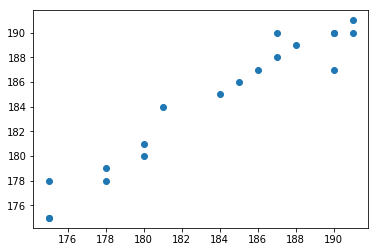

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(X, y);

### Defining the model
`y = c + m * x`

Where `c` is the y intercept, and `m` is te gradient

#### Least Mean Squares Algorithm

In [79]:
X_mean = np.mean(X)
y_mean = np.mean(y)

# print "Arr: ", X_flat
print X_mean, y_mean


X_mean_diff = X - X_mean 
y_mean_diff = y - y_mean

print "X: ", X

print X_mean_diff, y_mean_diff
X_square_diff = X_mean_diff * X_mean_diff

# print X_square_diff
mean_diff_product = map(lambda x, y: x * y, X_mean_diff, y_mean_diff)
print mean_diff_product

# print sum(X_mean_diff)

# y_hat = c + m*x
# # print X
# x_mean_diff
# m = sum((x(i) - mean(x)) * (y(i) - mean(y))) / sum( (x(i) - mean(x))^2 )
# c = mean(y) - B1 * mean(x)

183.736842105 184.368421053
X:  [[175]
 [175]
 [175]
 [178]
 [178]
 [180]
 [180]
 [181]
 [184]
 [185]
 [186]
 [187]
 [188]
 [191]
 [191]
 [190]
 [190]
 [187]
 [190]]
[[-8.73684211]
 [-8.73684211]
 [-8.73684211]
 [-5.73684211]
 [-5.73684211]
 [-3.73684211]
 [-3.73684211]
 [-2.73684211]
 [ 0.26315789]
 [ 1.26315789]
 [ 2.26315789]
 [ 3.26315789]
 [ 4.26315789]
 [ 7.26315789]
 [ 7.26315789]
 [ 6.26315789]
 [ 6.26315789]
 [ 3.26315789]
 [ 6.26315789]] [-9.36842105 -9.36842105 -6.36842105 -6.36842105 -5.36842105 -4.36842105
 -3.36842105 -0.36842105  0.63157895  1.63157895  2.63157895  3.63157895
  4.63157895  6.63157895  5.63157895  2.63157895  5.63157895  5.63157895
  5.63157895]
[array([ 81.85041551]), array([ 81.85041551]), array([ 55.6398892]), array([ 36.53462604]), array([ 30.79778393]), array([ 16.32409972]), array([ 12.58725762]), array([ 1.00831025]), array([ 0.16620499]), array([ 2.06094183]), array([ 5.95567867]), array([ 11.85041551]), array([ 19.74515235]), array([ 48.16620499]

### Calculating the slope (m)
Formula:

```m = sum((X - X_mean)(y - y_mean)) / sum((X - X_mean)**2) ```


In [80]:
m = np.sum(mean_diff_product) / np.sum(X_square_diff)
print m

# Mean points (X_mean, y_mean)
# Find c, the y intercept
# Substituting y_mean = c + m(X_mean)
# Therefore:
# y_mean - m(X_mean)
c = y_mean - (m * X_mean)
print c


0.918553624715
15.5962787432


Regression Line Formula:

```
y = 0.918553624715(X) + 15.5962787432
```

Thus, the line passes through point 15.596 on the y axis

### Cost Function (R Squared)

Calculate the y values for the regression line

In [82]:
def regression_model(m, c, x_value):
    return (m * x_value) + c
    

X_flat = X.flatten()
# print X_flat[0]
y_hat = []
for value in X.flatten():
    y_hat.append(regression_model(m, c, value))

y_hat
    

[176.34316306828157,
 176.34316306828157,
 176.34316306828157,
 179.09882394242584,
 179.09882394242584,
 180.93593119185536,
 180.93593119185536,
 181.85448481657014,
 184.61014569071443,
 185.52869931542918,
 186.44725294014395,
 187.3658065648587,
 188.28436018957348,
 191.04002106371775,
 191.04002106371775,
 190.121467439003,
 190.121467439003,
 187.3658065648587,
 190.121467439003]

#### Plot Regression line

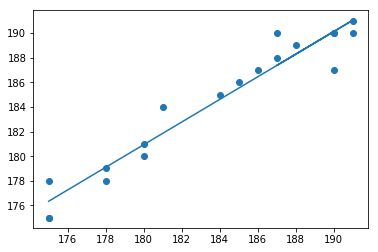

In [83]:
import matplotlib.pyplot as plt
m, c = np.polyfit(X.flatten(), y_hat, 1)
plt.scatter(X, y);
plt.plot(X, m*X + c, '-')

### Training the Data
The training is carried out using the cross validatoin method

In [32]:
# Use 20 percent of the data as testing data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.8)

#Fit the classifier
classifier = LinearRegression()
classifier.fit(X_train, y_train)
accuracy = classifier.score(X_test, y_test)

print accuracy

-0.0365996924174
